In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# work with the fastai V1 library which sits on top of Pytorch 1.0
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [3]:
df = pd.read_csv('/home/jramsay/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)

In [5]:
np.random.seed(42)
src = (ImageItemList.from_csv('/home/jramsay/', 'train_labels.csv', folder='train_img', suffix='.tif')
       .random_split_by_pct(0.05)
       .label_from_df(sep=' ')
       .add_test_folder(test_folder='test_img'))

In [6]:
data = (src.transform(tfms, size=96)
        .databunch().normalize(imagenet_stats))

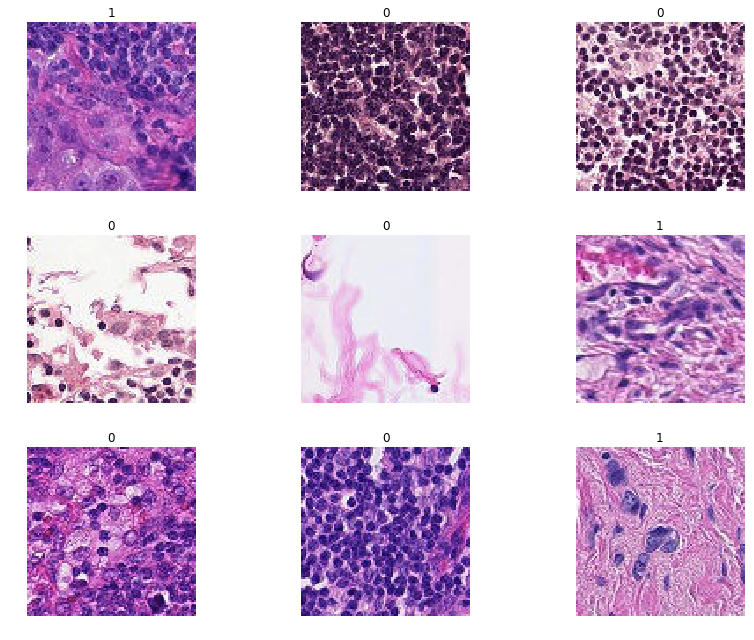

In [7]:
data.show_batch(rows=3, figsize=(12,9))

In [8]:
from sklearn.metrics import roc_auc_score
def auc_score(y_pred,y_true,tens=True):
    #score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    score=roc_auc_score(y_true,torch.sigmoid(y_pred))
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [9]:
from torchvision.models import *

In [10]:
#arch = models.dn121
#arch=dn121
#metrics=[auc_score]
#learn = create_cnn(data, arch, metrics)

learn = create_cnn(
    data,
    densenet121,
    metrics=[auc_score], 
    ps=0.8
)

/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


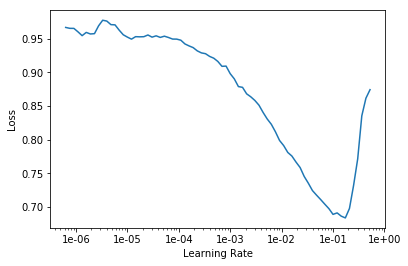

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
lr=3e-2

In [13]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,auc_score
1,0.243893,0.171699,0.978975
2,0.168902,0.116085,0.990288
3,0.136565,0.098161,0.993035


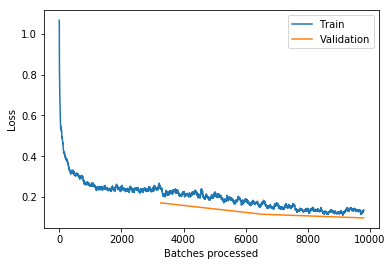

In [14]:
# Plot losses
learn.recorder.plot_losses()

In [15]:
learn.save('stage-1-96-dn121')

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


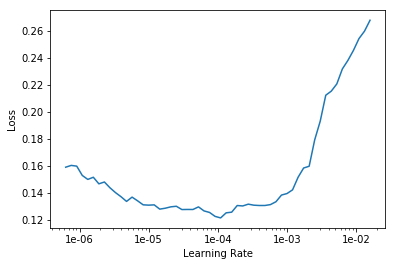

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(8, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,auc_score
1,0.127954,0.097561,0.992979
2,0.115738,0.092999,0.993601
3,0.114936,0.092886,0.993834
4,0.111478,0.085614,0.994275
5,0.115596,0.083235,0.994926
6,0.101674,0.080372,0.995070
7,0.101069,0.079859,0.995159
8,0.087296,0.079857,0.995174


In [20]:
# Save model
learn.save('stage-2-96-dn121')

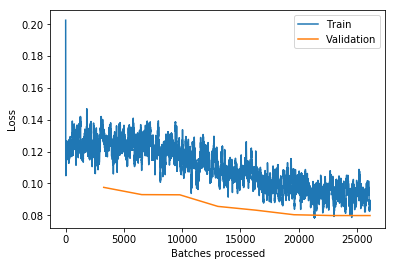

In [21]:
# Plot losses
learn.recorder.plot_losses()

In [ ]:
''' 
Code below here is to make predictions and submission
'''

In [22]:
# predict without tta
preds, y_test = learn.get_preds(ds_type=DatasetType.Test)

In [23]:
# predict with tta
preds_tta,y_test_tta=learn.TTA(ds_type=DatasetType.Test)

In [27]:
print(preds)

tensor([[7.0663e-01, 2.9337e-01],
        [3.5325e-02, 9.6467e-01],
        [3.8543e-02, 9.6146e-01],
        ...,
        [9.9934e-01, 6.5612e-04],
        [5.1406e-01, 4.8594e-01],
        [1.0282e-02, 9.8972e-01]])


In [28]:
print(preds_tta)

tensor([[7.5448e-01, 2.4552e-01],
        [6.1046e-02, 9.3895e-01],
        [5.8181e-02, 9.4182e-01],
        ...,
        [9.9973e-01, 2.7392e-04],
        [7.5732e-01, 2.4268e-01],
        [1.2041e-02, 9.8796e-01]])


In [29]:
sub=pd.read_csv('/home/jramsay/sample_submission.csv').set_index('id')
sub.head()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [30]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fname_cleaned=clean_fname(data.test_ds.items)
fname_cleaned=fname_cleaned.astype(str)

In [31]:
sub.loc[fname_cleaned,'label']=to_np(preds[:,1])
sub.to_csv('cancer_sub_v5_noTTA.csv')

In [32]:
sub.loc[fname_cleaned,'label']=to_np(preds_tta[:,1])
sub.to_csv('cancer_sub_v5_TTA.csv')

In [33]:
'''
Try using densenet 169
'''

'\nTry using densenet 169\n'

In [34]:
learn = create_cnn(
    data,
    densenet169,
    metrics=[auc_score], 
    ps=0.8
)

/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


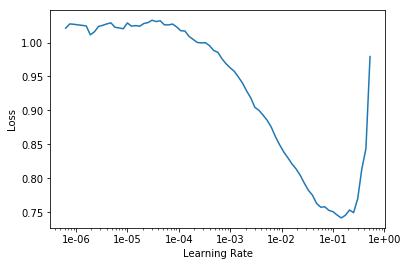

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
lr=2e-2
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,auc_score
1,0.202072,0.143088,0.985702
2,0.159583,0.108887,0.991485
3,0.129431,0.093664,0.993611


In [37]:
learn.save('stage-1-96-dn169')

In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(15, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,auc_score
1,0.113545,0.092706,0.993659
2,0.112511,0.093875,0.993959
3,0.108215,0.087310,0.994678
4,0.108860,0.081579,0.995322
5,0.104369,0.081157,0.995420
6,0.095091,0.076990,0.995972
7,0.099020,0.071624,0.996165
8,0.088031,0.068542,0.996400
9,0.070464,0.066394,0.996740
10,0.069996,0.064958,0.997054


KeyboardInterrupt: 

In [40]:
learn.save('stage-2-96-dn169')

In [41]:
# predict with tta
preds_tta,y_test_tta=learn.TTA(ds_type=DatasetType.Test)

In [42]:
sub.loc[fname_cleaned,'label']=to_np(preds_tta[:,1])
sub.to_csv('cancer_sub_v5_Den169_TTA.csv')

In [43]:
learn.fit_one_cycle(1, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,auc_score
1,0.068053,0.062967,0.997018


In [45]:
preds_tta,y_test_tta=learn.TTA(ds_type=DatasetType.Test)

In [46]:
sub.loc[fname_cleaned,'label']=to_np(preds_tta[:,1])
sub.to_csv('cancer_sub_v5_Den169_TTA.csv')